# WandB Training Analysis - Grid 4 Objects 9
Analysis of DDQN training runs for different path planning methods

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from wandb.proto import wandb_internal_pb2
from wandb.sdk.internal import datastore
from matplotlib.ticker import FuncFormatter

# Set style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 150  # Higher DPI for sharper text
plt.rcParams['savefig.dpi'] = 150  # Higher DPI for saved figures
plt.rcParams['text.antialiased'] = True  # Enable antialiasing
plt.rcParams['axes.edgecolor'] = '#333333'  # Sharper edge color

# Set Linux Libertine font (with fallback to serif fonts)
import matplotlib.font_manager as fm

# Try to use Linux Libertine, fallback to Times New Roman or other serif fonts
available_fonts = [f.name for f in fm.fontManager.ttflist]
if 'Linux Libertine' in available_fonts:
    plt.rcParams['font.family'] = 'Linux Libertine'
elif 'Linux Libertine O' in available_fonts:
    plt.rcParams['font.family'] = 'Linux Libertine O'
elif 'Times New Roman' in available_fonts:
    plt.rcParams['font.family'] = 'Times New Roman'
else:
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Liberation Serif']

print(f"Using font: {plt.rcParams['font.family']}")

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.titleweight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'

Using font: ['Linux Libertine']


In [2]:
# Define the runs to analyze
runs_to_analyze = {
    'A*': 'run-20251220_021934-saemm4ho',
    'RRT': 'run-20251220_134743-dbi680zb',
    'RRT IsaacSim': 'run-20251224_185719-q0xud95c'
}

wandb_dir = Path(r'C:\isaacsim\cobotproject\scripts\Reinforcement Learning\doubleDQN_script\wandb')

In [3]:
def extract_history_from_wandb(wandb_file_path, verbose=False):
    """Extract history data from wandb binary file"""
    
    ds = datastore.DataStore()
    ds.open_for_scan(str(wandb_file_path))
    
    history_data = []
    record_count = 0
    history_count = 0
    
    if verbose:
        print(f"Reading {wandb_file_path.name}...")
    
    while True:
        try:
            data = ds.scan_data()
            if data is None:
                break
            
            pb = wandb_internal_pb2.Record()
            pb.ParseFromString(data)
            
            record_count += 1
            record_type = pb.WhichOneof("record_type")
            
            if record_type == "history":
                history_count += 1
                metrics = {}
                
                for item in pb.history.item:
                    # The key is stored in nested_key field
                    if item.nested_key:
                        key = item.nested_key[0]
                    else:
                        key = item.key
                    
                    # Parse value
                    try:
                        value = json.loads(item.value_json)
                        metrics[key] = value
                    except:
                        try:
                            metrics[key] = float(item.value_json)
                        except:
                            metrics[key] = item.value_json
                
                history_data.append(metrics)
            
            if verbose and record_count % 50000 == 0:
                print(f"  Processed {record_count} records, {history_count} history records")
        
        except Exception as e:
            break
    
    if verbose:
        print(f"  Total: {record_count} records, {history_count} history records")
    
    return pd.DataFrame(history_data) if history_data else None

In [4]:
# Load all data
print("Loading data from wandb runs...")
print("="*80)

all_data = {}

for name, run_id in runs_to_analyze.items():
    run_dir = wandb_dir / run_id
    wandb_file = list(run_dir.glob('*.wandb'))[0]
    
    print(f"\n{name}:")
    df = extract_history_from_wandb(wandb_file, verbose=True)
    
    if df is not None and len(df) > 0:
        # Convert to numeric
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                pass
        
        all_data[name] = df
        print(f"  Loaded {len(df)} records")

Loading data from wandb runs...

A*:
Reading run-saemm4ho.wandb...
  Processed 50000 records, 16601 history records
  Processed 100000 records, 33229 history records
  Processed 150000 records, 49858 history records
  Total: 167160 records, 55556 history records
  Loaded 55556 records

RRT:
Reading run-dbi680zb.wandb...
  Processed 50000 records, 14094 history records
  Processed 100000 records, 27573 history records
  Processed 150000 records, 40955 history records
  Processed 200000 records, 54323 history records
  Total: 204648 records, 55556 history records
  Loaded 55556 records

RRT IsaacSim:
Reading run-q0xud95c.wandb...
  Processed 50000 records, 16221 history records
  Processed 100000 records, 32354 history records
  Processed 150000 records, 48387 history records
  Total: 172502 records, 55556 history records
  Loaded 55556 records


## 2. Smoothing Functions

In [5]:
def running_average(data, window=100):
    """Running average (moving average) smoothing"""
    return pd.Series(data).rolling(window=window, min_periods=1, center=False).mean().values

## 3. Epsilon Decay Analysis

In [6]:
# Analyze when epsilon reached 0.01 for each planner
print("Epsilon Decay Analysis:")
print("=" * 80)

for name, df in all_data.items():
    # Find epsilon column
    epsilon_col = None
    for col in df.columns:
        if 'epsilon' in col.lower():
            epsilon_col = col
            break
    
    # Find episode column
    episode_col = None
    for col in df.columns:
        if 'episode' in col.lower():
            episode_col = col
            break
    
    if epsilon_col and episode_col:
        # Find when epsilon reached 0.01 (or very close)
        epsilon_01_mask = df[epsilon_col] <= 0.011  # Small tolerance
        if epsilon_01_mask.any():
            first_episode = df.loc[epsilon_01_mask, episode_col].iloc[0]
            print(f'{name}: Epsilon reached 0.01 at episode {int(first_episode)}')
            print(f'  - Epsilon range: {df[epsilon_col].min():.4f} to {df[epsilon_col].max():.4f}')
            print(f'  - Total episodes: {int(df[episode_col].max())}')
        else:
            print(f'{name}: Epsilon never reached 0.01')
    print()

Epsilon Decay Analysis:
A*: Epsilon reached 0.01 at episode 1
  - Epsilon range: 0.0100 to 1.0000
  - Total episodes: 9

RRT: Epsilon reached 0.01 at episode 1
  - Epsilon range: 0.0100 to 1.0000
  - Total episodes: 9

RRT IsaacSim: Epsilon reached 0.01 at episode 1
  - Epsilon range: 0.0100 to 1.0000
  - Total episodes: 9



## 4. Visualization

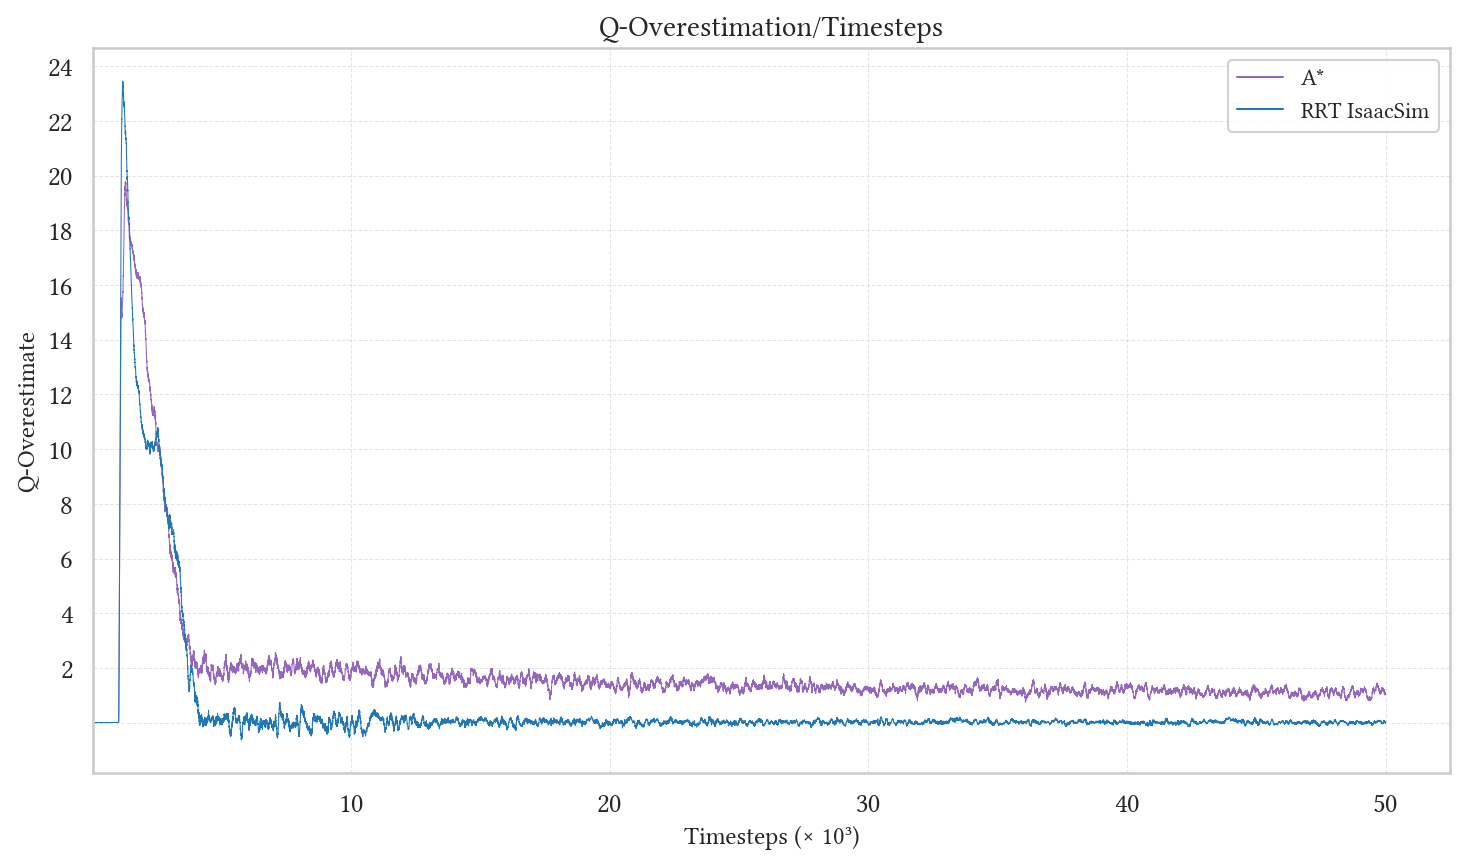

In [7]:
# Use tab10 color palette with purple for A*, blue for RRT IsaacSim, green for RRT
tab10_colors = sns.color_palette('tab10', 10)

color_map = {
    'A*': tab10_colors[4],          # Purple (index 4 in tab10)
    'RRT': tab10_colors[2],         # Green (index 2 in tab10)
    'RRT IsaacSim': tab10_colors[0] # Blue (index 0 in tab10)
}

# Formatter for x-axis to show timesteps in scientific notation (x 10^3)
# Hide 0 on x-axis
def thousands_formatter(x, pos):
    if x == 0:
        return ''
    return f'{int(x/1000)}'

# Create plot with seaborn style - SMOOTHED VERSION - A* and RRT IsaacSim ONLY
# Use context manager to preserve font settings
with sns.axes_style("whitegrid", rc={'font.family': plt.rcParams['font.family']}):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for name, df in all_data.items():
        # Only plot A* and RRT IsaacSim
        if name not in ['A*', 'RRT IsaacSim']:
            continue
            
        df_sorted = df.sort_values('global_step').reset_index(drop=True)
        
        x = df_sorted['global_step'].values
        y = df_sorted['ddqn/q_overestimation'].values
        
        # Apply running average smoothing
        y_smooth = running_average(y, window=100)
        
        # Plot with original linewidth
        ax.plot(x, y_smooth, label=name, color=color_map[name], linewidth=0.5, alpha=1.0)
    
    ax.set_xlabel('Timesteps (× 10³)', fontsize=12)
    ax.set_ylabel('Q-Overestimate', fontsize=12)
    ax.set_title('Q-Overestimation/Timesteps', fontsize=14, fontweight='normal')
    
    # Make legend with moderately thicker lines
    legend = ax.legend(fontsize=11, loc='best', framealpha=0.9)
    for line in legend.get_lines():
        line.set_linewidth(1.0)  # Legend line width
    ax.grid(True, alpha=0.5, linestyle='--', linewidth=0.5)
    
    # Format x-axis to show thousands (hide 0)
    ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    # Set x-axis to start from 0 (no gap at origin)
    ax.set_xlim(left=0)
    
    # Set y-axis ticks at even intervals (-2, 0, 2, 4, ...)
    from matplotlib.ticker import MultipleLocator, FuncFormatter as FF
    ax.yaxis.set_major_locator(MultipleLocator(2))
    
    # Hide 0 on y-axis
    def hide_zero_y(y, pos):
        if y == 0:
            return ''
        return f'{int(y)}'
    ax.yaxis.set_major_formatter(FF(hide_zero_y))
    
    plt.tight_layout()
    plt.show()

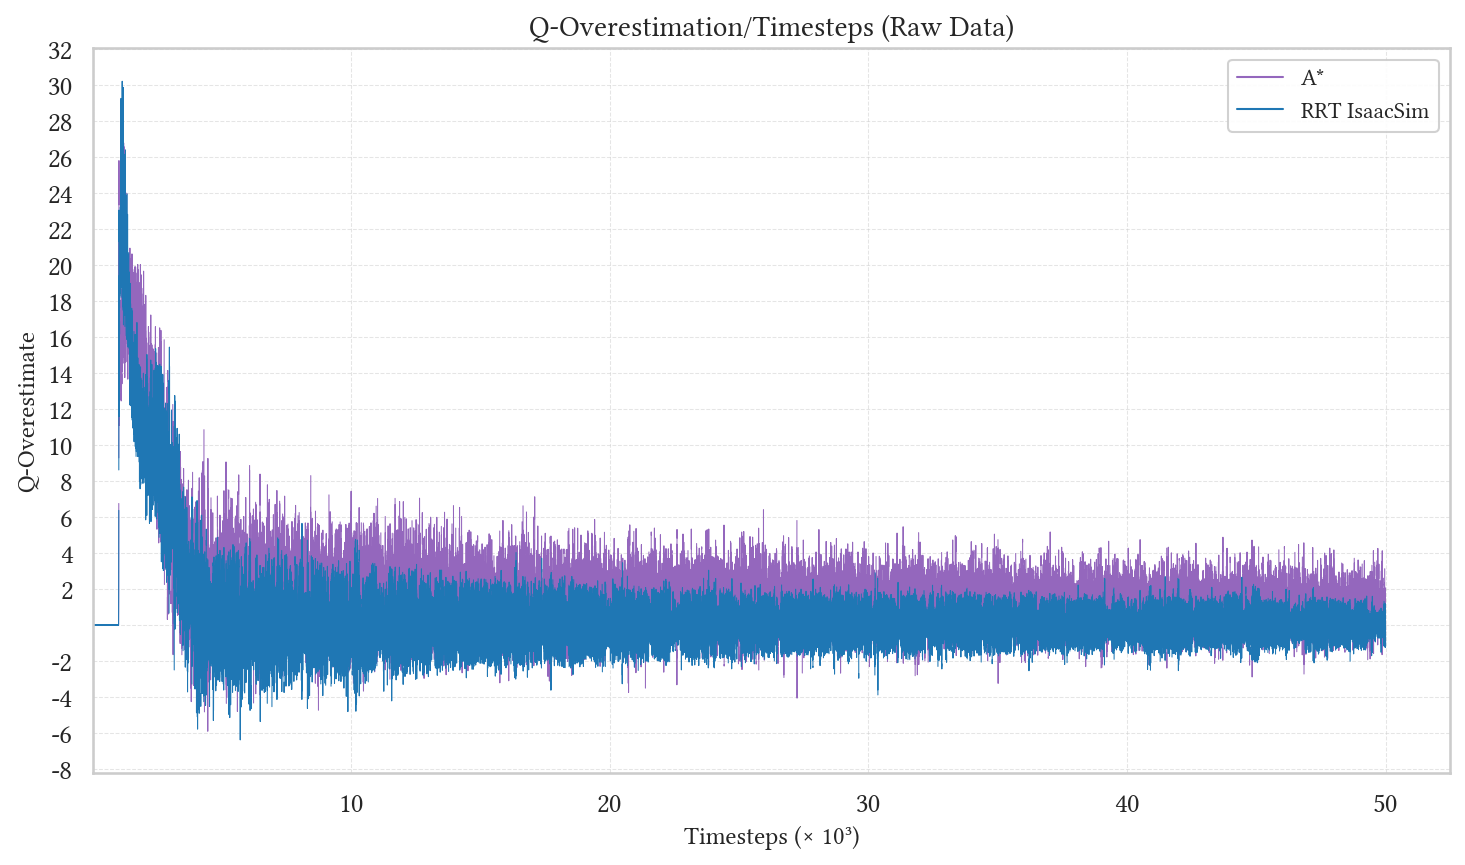

In [8]:
# Create plot with seaborn style - NO SMOOTHING VERSION - A* and RRT IsaacSim ONLY
# Use context manager to preserve font settings
with sns.axes_style("whitegrid", rc={'font.family': plt.rcParams['font.family']}):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for name, df in all_data.items():
        # Only plot A* and RRT IsaacSim
        if name not in ['A*', 'RRT IsaacSim']:
            continue
            
        df_sorted = df.sort_values('global_step').reset_index(drop=True)
        
        x = df_sorted['global_step'].values
        y = df_sorted['ddqn/q_overestimation'].values
        
        # Plot raw data without smoothing
        ax.plot(x, y, label=name, color=color_map[name], linewidth=0.5, alpha=1.0)
    
    ax.set_xlabel('Timesteps (× 10³)', fontsize=12)
    ax.set_ylabel('Q-Overestimate', fontsize=12)
    ax.set_title('Q-Overestimation/Timesteps (Raw Data)', fontsize=14, fontweight='normal')
    
    # Make legend with moderately thicker lines
    legend = ax.legend(fontsize=11, loc='best', framealpha=0.9)
    for line in legend.get_lines():
        line.set_linewidth(1.0)  # Legend line width
    ax.grid(True, alpha=0.5, linestyle='--', linewidth=0.5)
    
    # Format x-axis to show thousands (hide 0)
    ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    # Set x-axis to start from 0 (no gap at origin)
    ax.set_xlim(left=0)
    
    # Set y-axis ticks at even intervals (-2, 0, 2, 4, ...)
    from matplotlib.ticker import MultipleLocator, FuncFormatter as FF
    ax.yaxis.set_major_locator(MultipleLocator(2))
    
    # Hide 0 on y-axis
    def hide_zero_y(y, pos):
        if y == 0:
            return ''
        return f'{int(y)}'
    ax.yaxis.set_major_formatter(FF(hide_zero_y))
    
    plt.tight_layout()
    plt.show()

## 4. Reward Analysis - Grid 4x4, 9 Objects (from WandB)

**Instructions:**
- Run cells in order from top to bottom
- To run only Q-overestimation graphs: Run cells 1-6 only
- To run only Reward graphs: Run cells 1-5, then skip to cell 7+
- Each visualization section is clearly marked

### 4.1 Extract Episode Reward Data from WandB

In [9]:
# Extract episode/total_reward from the WandB data we already loaded
# We'll track episode number instead of timestep
reward_by_episode = {}

for name, df in all_data.items():
    # Check if episode/total_reward column exists
    reward_col = None
    for col in df.columns:
        if 'episode' in col.lower() and 'total' in col.lower() and 'reward' in col.lower():
            reward_col = col
            break
    
    if reward_col is None:
        print(f"Warning: No episode/total_reward column found for {name}")
        print(f"  Available columns: {list(df.columns)}")
        continue
    
    # Sort by global_step
    df_sorted = df.sort_values('global_step').reset_index(drop=True)
    
    # Create episode numbers (1-indexed: 1, 2, 3, ...)
    episode_numbers = np.arange(1, len(df_sorted) + 1)
    
    # Extract episode and reward
    reward_by_episode[name] = pd.DataFrame({
        'Episode': episode_numbers,
        'Reward': df_sorted[reward_col].values
    })
    
    print(f"{name}: {len(reward_by_episode[name])} episodes")
    print(f"  Episode range: {reward_by_episode[name]['Episode'].min()} - {reward_by_episode[name]['Episode'].max()}")
    print(f"  Reward range: {reward_by_episode[name]['Reward'].min():.2f} - {reward_by_episode[name]['Reward'].max():.2f}")
    print()

A*: 55556 episodes
  Episode range: 1 - 55556
  Reward range: 64.47 - 204.60

RRT: 55556 episodes
  Episode range: 1 - 55556
  Reward range: 102.38 - 265.90

RRT IsaacSim: 55556 episodes
  Episode range: 1 - 55556
  Reward range: 48.85 - 151.50



### 4.2 Apply Smoothing to Reward Data

In [10]:
# Apply running average smoothing with larger window to reduce peaks
# A* shows more variance, so we need stronger smoothing
smoothing_window = 200  # Much larger window for smoother curves (was 100)

BASE_REWARD_PER_PICK = 10.0  # Base reward per successful pick
NUM_OBJECTS = 9  # Number of objects per episode (grid_size=3 -> 9 objects)
BASE_REWARD_PER_EPISODE = BASE_REWARD_PER_PICK * NUM_OBJECTS  # 10.0 × 9 = 90.0

reward_smoothed = {}

for name, data in reward_by_episode.items():
    # Apply running average (rolling mean)
    smoothed_rewards = running_average(data['Reward'].values, window=smoothing_window)
    
    # Create DataFrame with smoothed data (no artificial base reward point)
    reward_smoothed[name] = pd.DataFrame({
        'Episode': data['Episode'].values,
        'Reward': smoothed_rewards
    })
    
    print(f"{name}: Smoothed with window={smoothing_window}")
    print(f"  Episode range: {reward_smoothed[name]['Episode'].min()} - {reward_smoothed[name]['Episode'].max()}")
    print(f"  Reward range after smoothing: {reward_smoothed[name]['Reward'].min():.2f} - {reward_smoothed[name]['Reward'].max():.2f}")

A*: Smoothed with window=200
  Episode range: 1 - 55556
  Reward range after smoothing: 141.67 - 162.79
RRT: Smoothed with window=200
  Episode range: 1 - 55556
  Reward range after smoothing: 177.99 - 217.98
RRT IsaacSim: Smoothed with window=200
  Episode range: 1 - 55556
  Reward range after smoothing: 135.79 - 151.46


### 4.3 Line Graph - Episode / Reward (Smoothed)

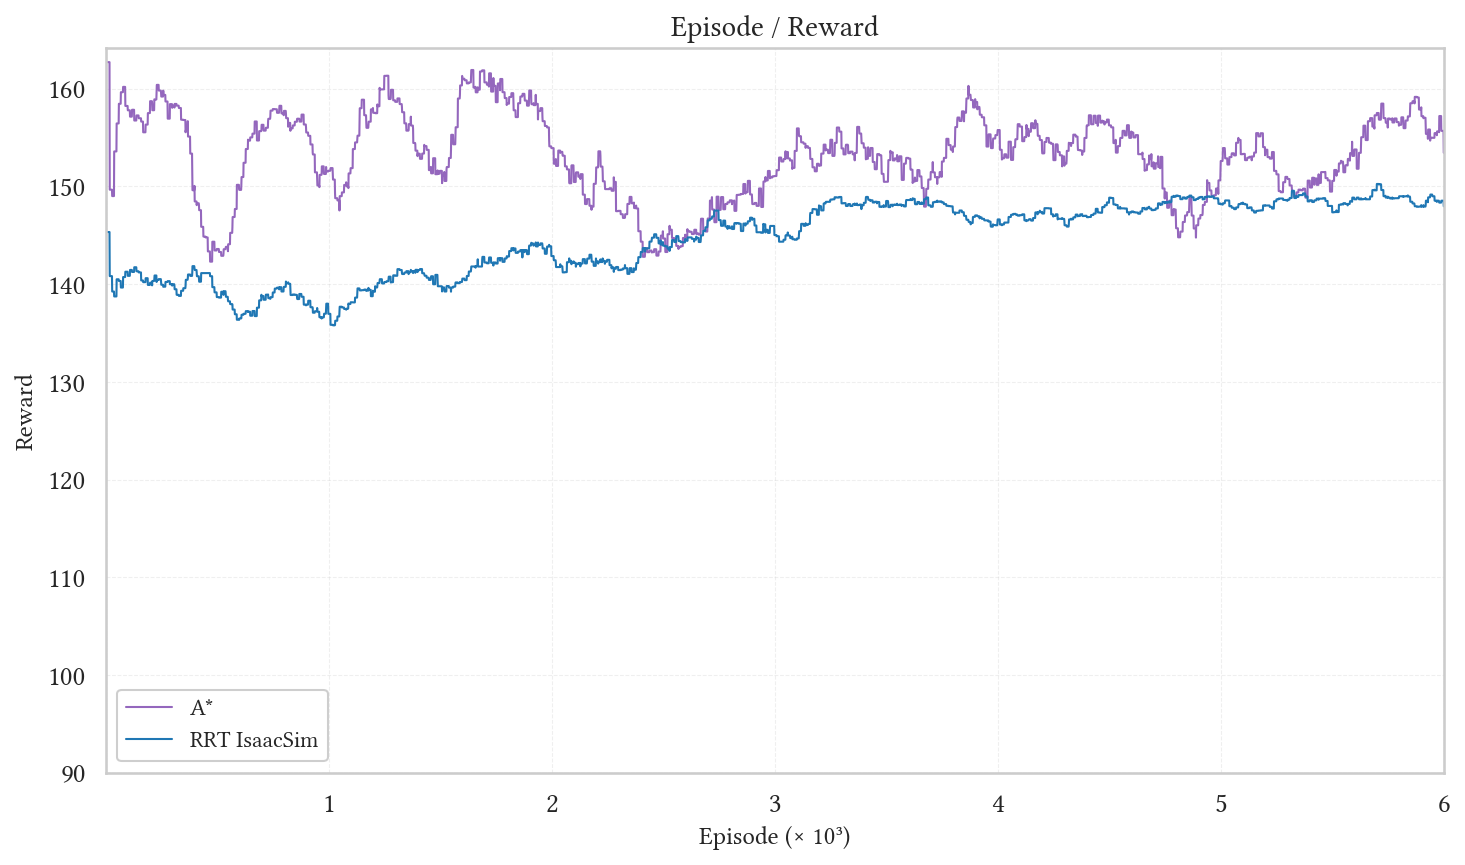

In [11]:
# Use same colors as Q-overestimation graph (muted palette)
# A* = muted teal/green, RRT IsaacSim = muted blue/purple
reward_color_map = color_map  # Reuse the same color map from Q-overestimation

# Formatter for x-axis to show episodes in thousands (hide 0, show 1, 2, 3, 4, 5, 6)
def episode_thousands_formatter(x, pos):
    if x == 0:
        return ''
    return f'{int(x/1000)}'

# Create line plot with smooth continuous lines (NO markers)
with sns.axes_style("whitegrid", rc={'font.family': plt.rcParams['font.family']}):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each method as a continuous line (smoothed data for wave effect)
    for method in ['A*', 'RRT IsaacSim']:  # Only plot A* and RRT IsaacSim
        if method in reward_smoothed:
            data = reward_smoothed[method]
            
            # Plot continuous line WITHOUT markers
            ax.plot(
                data['Episode'], 
                data['Reward'], 
                label=method, 
                color=reward_color_map[method], 
                linewidth=1.0,  # Match seaborn example linewidth
                alpha=1.0
            )
    
    ax.set_xlabel('Episode (× 10³)', fontsize=12)  # Show episodes in thousands
    ax.set_ylabel('Reward', fontsize=12)
    ax.set_title('Episode / Reward', fontsize=14, fontweight='normal')
    
    # Set x-axis limits and ticks
    ax.set_xlim(left=0, right=6000)  # 0 to 6000 episodes
    
    # Format x-axis to show ONLY: 0, 1, 2, 3, 4, 5, 6 (in thousands)
    ax.set_xticks([0, 1000, 2000, 3000, 4000, 5000, 6000])  # Explicit tick positions
    ax.xaxis.set_major_formatter(FuncFormatter(episode_thousands_formatter))
    
    # Set y-axis to start from base reward per episode (90.0 = 10.0 × 9 objects)
    ax.set_ylim(bottom=90.0)
    
    # Improve legend
    ax.legend(fontsize=11, loc='best', framealpha=0.95)
    
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

### 4.3b Bar Graph - Episode / Reward (Smoothed)

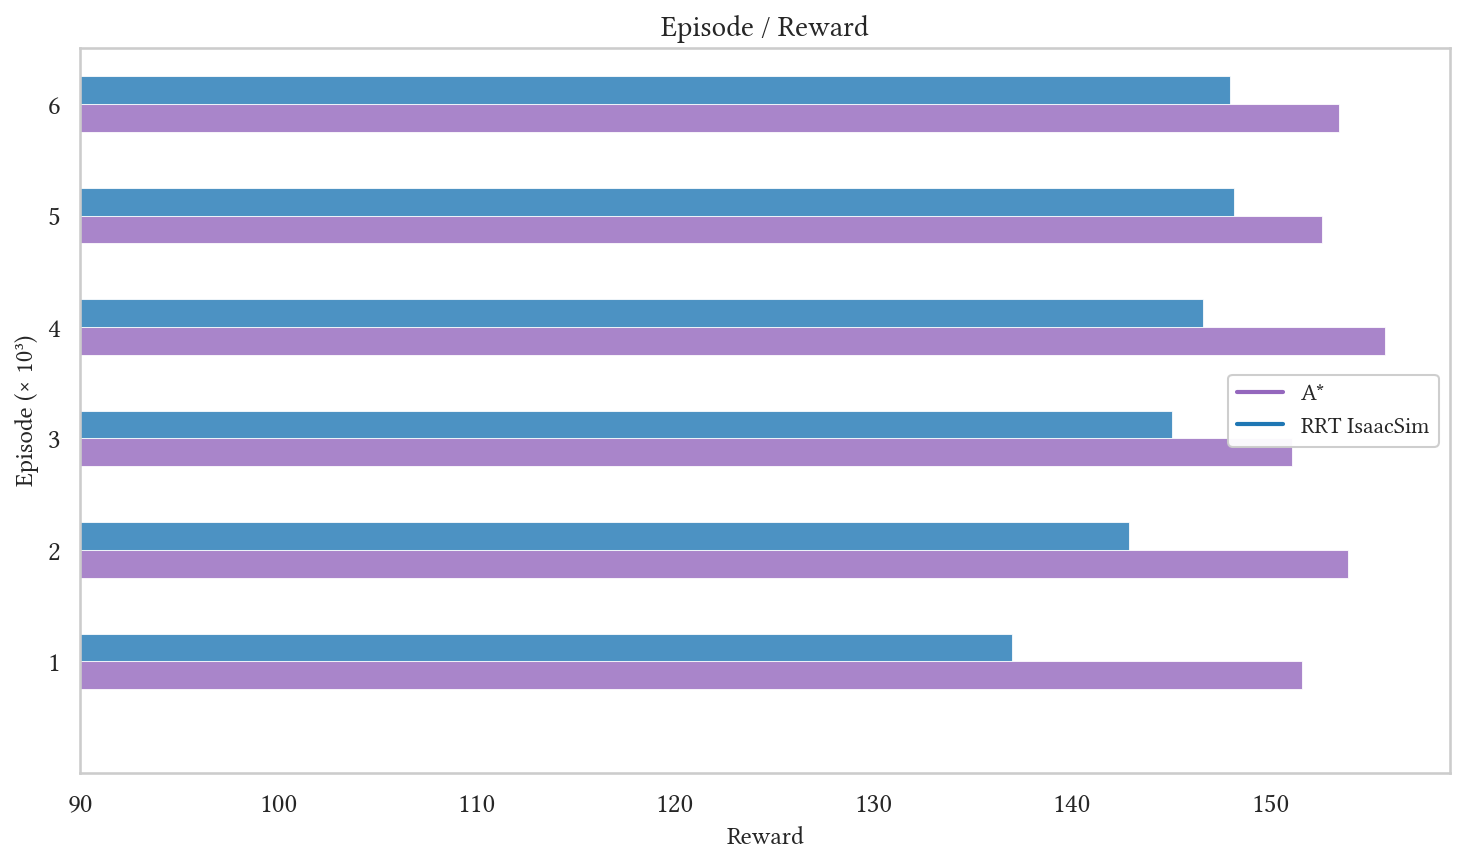

In [12]:
# Create horizontal bar graph version with purple for A* and blue for RRT IsaacSim
# Use tab10 colors: purple (index 4) and blue (index 0)
bar_color_map = {
    'A*': tab10_colors[4],          # Purple (index 4 in tab10)
    'RRT IsaacSim': tab10_colors[0] # Blue (index 0 in tab10)
}

# Create horizontal bar plot
with sns.axes_style("whitegrid", rc={'font.family': plt.rcParams['font.family']}):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data for grouped bar chart
    # Sample every 1000 episodes
    # Range: Episodes 0, 1000, 2000, 3000, 4000, 5000, 6000 (7 bars total)
    sample_interval = 1000  # Show bars every 1000 episodes
    
    bar_height = 0.25  # Height of each bar (thinner)
    
    # Get episode positions (0, 1, 2, 3, 4, 5, 6 for thousands)
    episodes_to_sample = [0, 1000, 2000, 3000, 4000, 5000, 6000]
    y_positions = np.arange(len(episodes_to_sample))  # 0, 1, 2, 3, 4, 5, 6
    
    for i, method in enumerate(['A*', 'RRT IsaacSim']):
        if method in reward_smoothed:
            data = reward_smoothed[method]
            
            # Get rewards at specific episodes
            rewards = []
            for ep in episodes_to_sample:
                # Find closest episode in data
                closest_idx = (data['Episode'] - ep).abs().idxmin()
                rewards.append(data.loc[closest_idx, 'Reward'])
            
            # Offset bars for grouped display
            y_offset = (i - 0.5) * bar_height
            y = y_positions + y_offset
            
            # Plot horizontal bars
            ax.barh(
                y, 
                np.array(rewards) - 90.0,  # Width from baseline (90.0)
                height=bar_height,
                left=90.0,  # Start from baseline
                label=method, 
                color=bar_color_map[method], 
                alpha=0.8,
                edgecolor='white',
                linewidth=0.5
            )
    
    ax.set_ylabel('Episode (× 10³)', fontsize=12)
    ax.set_xlabel('Reward', fontsize=12)
    ax.set_title('Episode / Reward', fontsize=14, fontweight='normal')
    
    # Set y-axis ticks and labels - start from 0 at intersection (hide 0 label)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(['', '1', '2', '3', '4', '5', '6'])  # Hide 0, show 1-6
    ax.set_ylim(bottom=0, top=len(episodes_to_sample) - 0.5)  # Start y-axis at 0
    
    # Set x-axis to start from base reward per episode (90.0)
    ax.set_xlim(left=90.0)
    
    # Create legend with lines instead of boxes, positioned on the right
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=bar_color_map['A*'], lw=2, label='A*'),
        Line2D([0], [0], color=bar_color_map['RRT IsaacSim'], lw=2, label='RRT IsaacSim')
    ]
    ax.legend(handles=legend_elements, fontsize=11, loc='center right', framealpha=0.95)
    
    # Remove grid
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()

### 4.4 Average Reward per 10 Episodes (Calculation Data)

In [13]:
# Calculate average reward for every 10 episodes (changed from 100)
print("Average Reward per 10 Episodes:\n" + "="*80)

reward_avg_10 = {}
BASE_REWARD_PER_PICK = 10.0  # Base reward per successful pick
NUM_OBJECTS = 9  # Number of objects per episode (grid_size=3 -> 9 objects)
BASE_REWARD_PER_EPISODE = BASE_REWARD_PER_PICK * NUM_OBJECTS  # 10.0 × 9 = 90.0

for name, data in reward_by_episode.items():
    print(f"\n{name}:")
    print("-" * 60)
    
    # Group episodes into bins of 10 (changed from 100)
    data['Episode_Bin'] = (data['Episode'] - 1) // 10  # 0-9 -> bin 0, 10-19 -> bin 1, etc.
    
    # Calculate average reward per bin
    avg_per_bin = data.groupby('Episode_Bin')['Reward'].agg(['mean', 'std', 'count']).reset_index()
    
    # Create episode range labels (e.g., '1-10', '11-20', etc.)
    avg_per_bin['Episode_Range'] = avg_per_bin['Episode_Bin'].apply(
        lambda x: f"{x*10 + 1}-{min((x+1)*10, data['Episode'].max())}"
    )
    
    # Store for plotting (no artificial base reward point)
    reward_avg_10[name] = avg_per_bin
    
    # Display first 20 bins and last 5 bins
    print("\nFirst 20 bins (Episodes 1-200):")
    print(avg_per_bin[['Episode_Range', 'mean', 'std', 'count']].head(20).to_string(index=False))
    
    print("\n...")
    
    print("\nLast 5 bins:")
    print(avg_per_bin[['Episode_Range', 'mean', 'std', 'count']].tail(5).to_string(index=False))
    
    print(f"\nOverall Statistics:")
    print(f"  Total bins: {len(avg_per_bin)}")
    print(f"  Overall mean reward: {data['Reward'].mean():.2f}")
    print(f"  Overall std reward: {data['Reward'].std():.2f}")

Average Reward per 10 Episodes:

A*:
------------------------------------------------------------

First 20 bins (Episodes 1-200):
Episode_Range       mean  std  count
         1-10 162.719910  NaN      1
        11-20 136.623504  NaN      1
        21-30 147.709444  NaN      1
        31-40 167.286487  NaN      1
        41-50 167.903392  NaN      1
        51-60 168.520016  NaN      1
        61-70 166.744779  NaN      1
        71-80 164.011915  NaN      1
        81-90 142.647163  NaN      1
       91-100 153.764180  NaN      1
      101-110 150.653603  NaN      1
      111-120 165.597676  NaN      1
      121-130 143.550668  NaN      1
      131-140 164.017808  NaN      1
      141-150 152.943542  NaN      1
      151-160 151.524578  NaN      1
      161-170 138.011123  NaN      1
      171-180 169.742543  NaN      1
      181-190 178.676180  NaN      1
      191-200 181.859026  NaN      1

...

Last 5 bins:
Episode_Range       mean  std  count
  55511-55520 162.223833  NaN      1

### 4.5 Line Graph - Average Reward per 10 Episodes (with Markers)

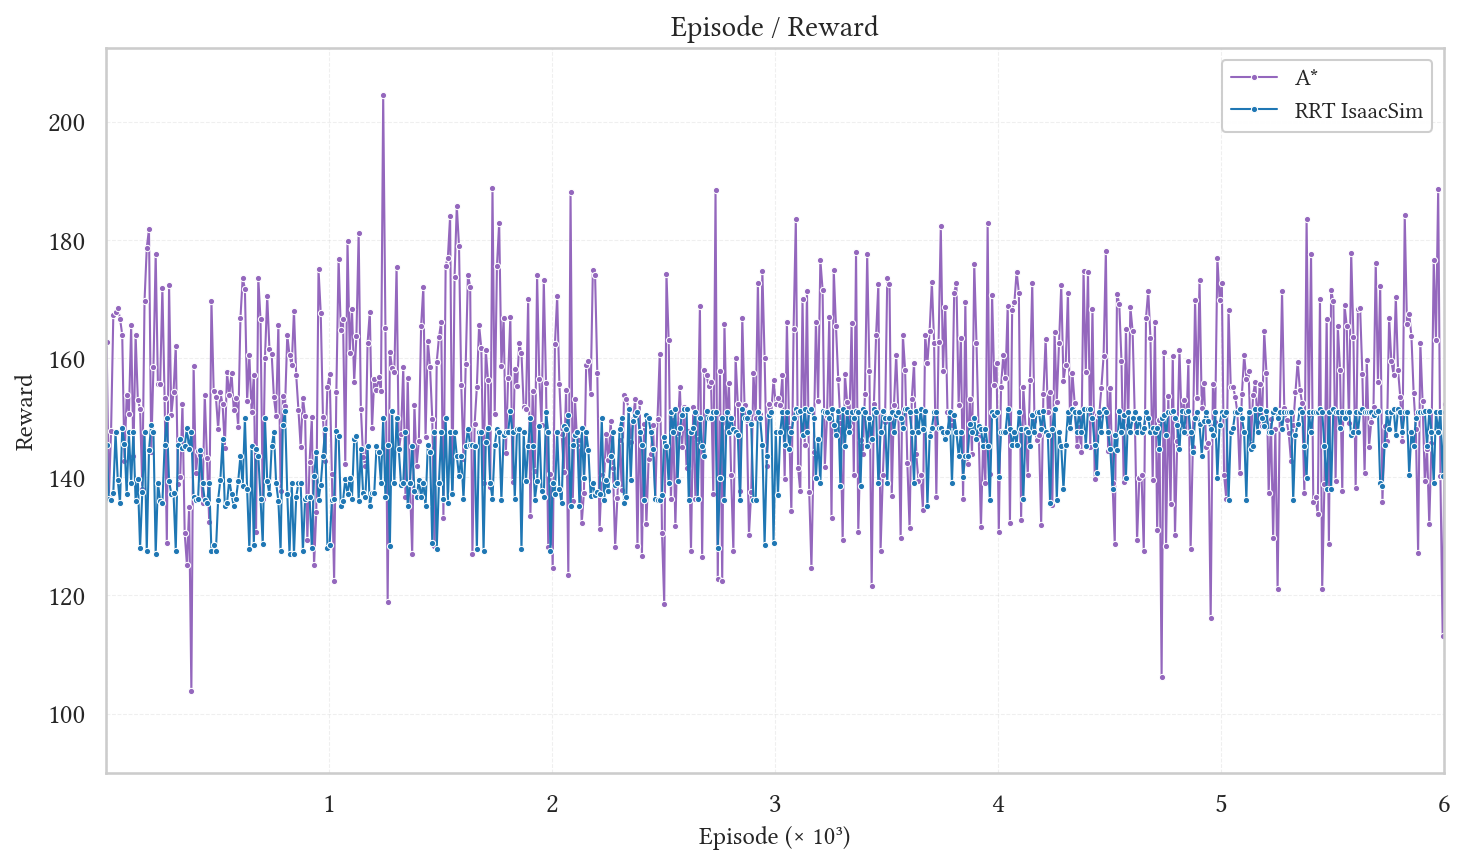

In [14]:
# Plot average reward per 10 episodes with circle markers
with sns.axes_style("whitegrid", rc={'font.family': plt.rcParams['font.family']}):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for method in ['A*', 'RRT IsaacSim']:
        if method in reward_avg_10:
            data = reward_avg_10[method]
            
            # Convert bin number to episode number (center of each bin)
            # Bin 0 (episodes 1-10) -> episode 5 (center)
            # Bin 1 (episodes 11-20) -> episode 15 (center)
            x = (data['Episode_Bin'] * 10) + 5
            y = data['mean']
            
            # Plot line with circle markers
            ax.plot(
                x, 
                y, 
                label=method, 
                color=color_map[method], 
                linewidth=1.0,        # Match seaborn example linewidth
                marker='o',           # Circle markers
                markersize=3,         # Small markers
                markerfacecolor=color_map[method],
                markeredgewidth=0.5,
                markeredgecolor='white',
                alpha=1.0
            )
    
    ax.set_xlabel('Episode (× 10³)', fontsize=12)
    ax.set_ylabel('Reward', fontsize=12)  # Same as smoothed graph
    ax.set_title('Episode / Reward', fontsize=14, fontweight='normal')  # Same title
    
    # Set x-axis limits and ticks
    ax.set_xlim(left=0, right=6000)
    ax.set_xticks([0, 1000, 2000, 3000, 4000, 5000, 6000])
    ax.xaxis.set_major_formatter(FuncFormatter(episode_thousands_formatter))
    
    # Set y-axis to start from base reward per episode (90.0 = 10.0 × 9 objects)
    ax.set_ylim(bottom=90.0)
    
    ax.legend(fontsize=11, loc='best', framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

## 5. Loss Analysis - Training Loss Visualizations

**Visualization approaches to analyze training loss:**
1. Loss Distribution Box Plot
2. Loss Histogram/Distribution

### 5.1 Extract Loss Data from WandB

In [15]:
# Extract training/loss from the WandB data we already loaded
loss_by_timestep = {}

for name, df in all_data.items():
    # Check if training/loss column exists
    loss_col = None
    for col in df.columns:
        if 'training' in col.lower() and 'loss' in col.lower():
            loss_col = col
            break
    
    if loss_col is None:
        print(f"Warning: No training/loss column found for {name}")
        print(f"  Available columns: {list(df.columns)}")
        continue
    
    # Sort by global_step
    df_sorted = df.sort_values('global_step').reset_index(drop=True)
    
    # Extract timestep and loss (filter out zero/null losses)
    valid_mask = (df_sorted[loss_col] > 0) & (df_sorted[loss_col].notna())
    
    loss_by_timestep[name] = pd.DataFrame({
        'Timestep': df_sorted.loc[valid_mask, 'global_step'].values,
        'Loss': df_sorted.loc[valid_mask, loss_col].values
    })
    
    print(f"{name}: {len(loss_by_timestep[name])} loss records")
    print(f"  Timestep range: {loss_by_timestep[name]['Timestep'].min()} - {loss_by_timestep[name]['Timestep'].max()}")
    print(f"  Loss range: {loss_by_timestep[name]['Loss'].min():.4f} - {loss_by_timestep[name]['Loss'].max():.4f}")
    print(f"  Mean loss: {loss_by_timestep[name]['Loss'].mean():.4f}")
    print()

A*: 49001 loss records
  Timestep range: 1000 - 50000
  Loss range: 1.7136 - 18.5439
  Mean loss: 3.1184

RRT: 49001 loss records
  Timestep range: 1000 - 50000
  Loss range: 1.6324 - 22.0514
  Mean loss: 3.6352

RRT IsaacSim: 49001 loss records
  Timestep range: 1000 - 50000
  Loss range: 0.0120 - 17.6406
  Mean loss: 0.6038



### 5.2 Loss Distribution Box Plot

C:\Users\Simulation\AppData\Local\Temp\ipykernel_20552\1682539868.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,


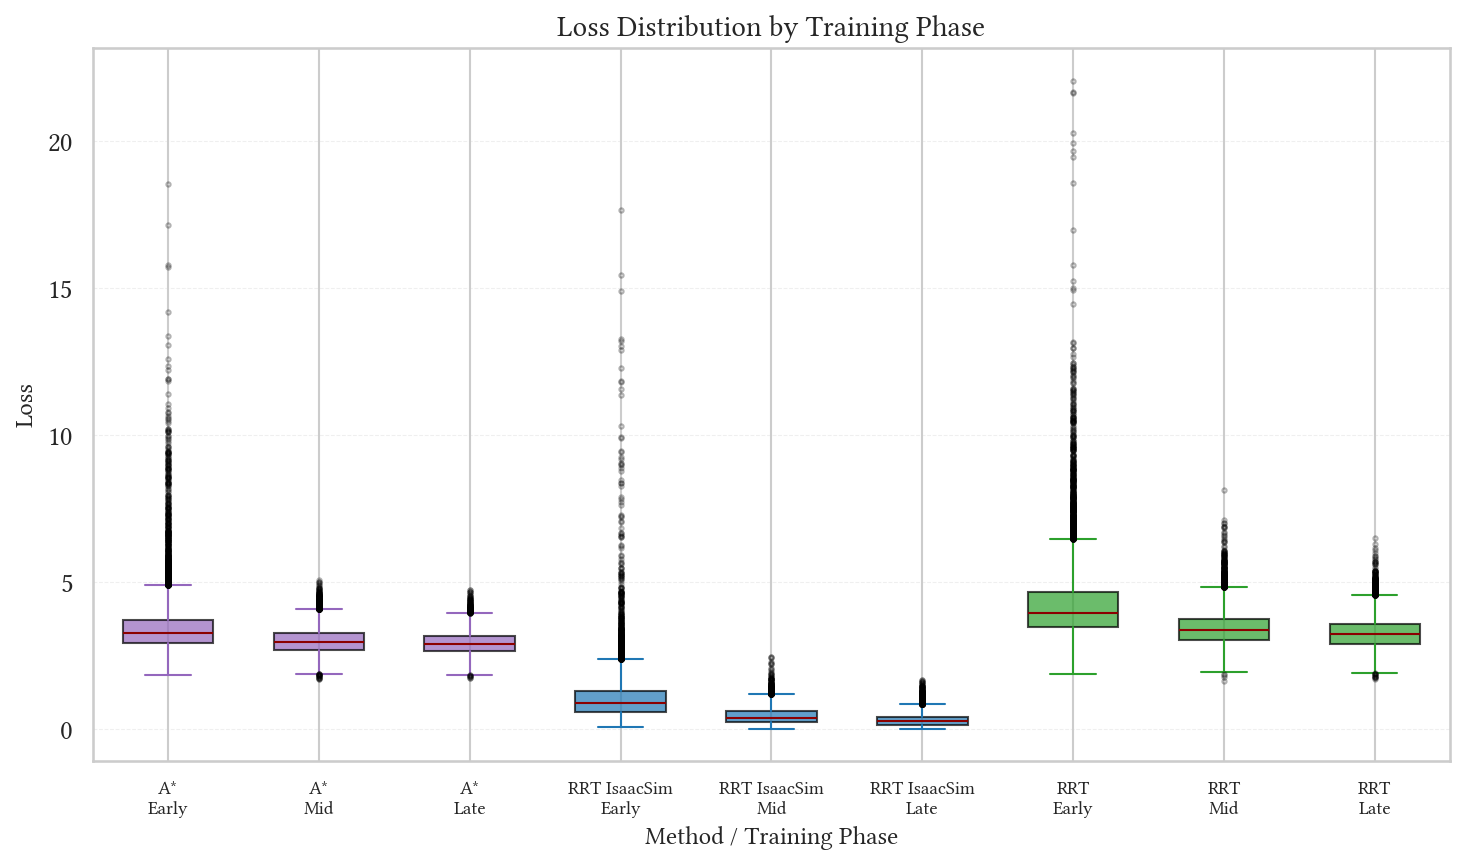

In [16]:
# Box plot showing loss distribution across training phases
# Divide training into 3 phases: Early, Mid, Late (without percentages)

with sns.axes_style("whitegrid", rc={'font.family': plt.rcParams['font.family']}):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data for box plot
    box_data = []
    box_labels = []
    box_colors = []
    
    phases = ['Early', 'Mid', 'Late']  # Removed percentages
    
    for name in ['A*', 'RRT IsaacSim', 'RRT']:
        if name in loss_by_timestep:
            data = loss_by_timestep[name]
            total_steps = len(data)
            
            # Divide into 3 phases
            phase_1 = data['Loss'].iloc[:total_steps//3]
            phase_2 = data['Loss'].iloc[total_steps//3:2*total_steps//3]
            phase_3 = data['Loss'].iloc[2*total_steps//3:]
            
            for i, phase_data in enumerate([phase_1, phase_2, phase_3]):
                box_data.append(phase_data.values)
                box_labels.append(f"{name}\n{phases[i]}")
                box_colors.append(color_map[name])
    
    # Create box plot
    bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                     widths=0.6, showfliers=True,
                     flierprops=dict(marker='o', markersize=2, alpha=0.3))
    
    # Color boxes
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Color whiskers, caps, and medians
    for i, color in enumerate(box_colors):
        bp['whiskers'][i*2].set_color(color)
        bp['whiskers'][i*2+1].set_color(color)
        bp['caps'][i*2].set_color(color)
        bp['caps'][i*2+1].set_color(color)
        bp['medians'][i].set_color('darkred')
        bp['medians'][i].set_linewidth(1)  # Reduced from 2 to 1 (half width)
    
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_xlabel('Method / Training Phase', fontsize=12)
    ax.set_title('Loss Distribution by Training Phase', fontsize=14, fontweight='normal')
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=0, ha='center', fontsize=9)
    
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
    
    plt.tight_layout()
    plt.show()

### 5.3 Loss Histogram/Distribution

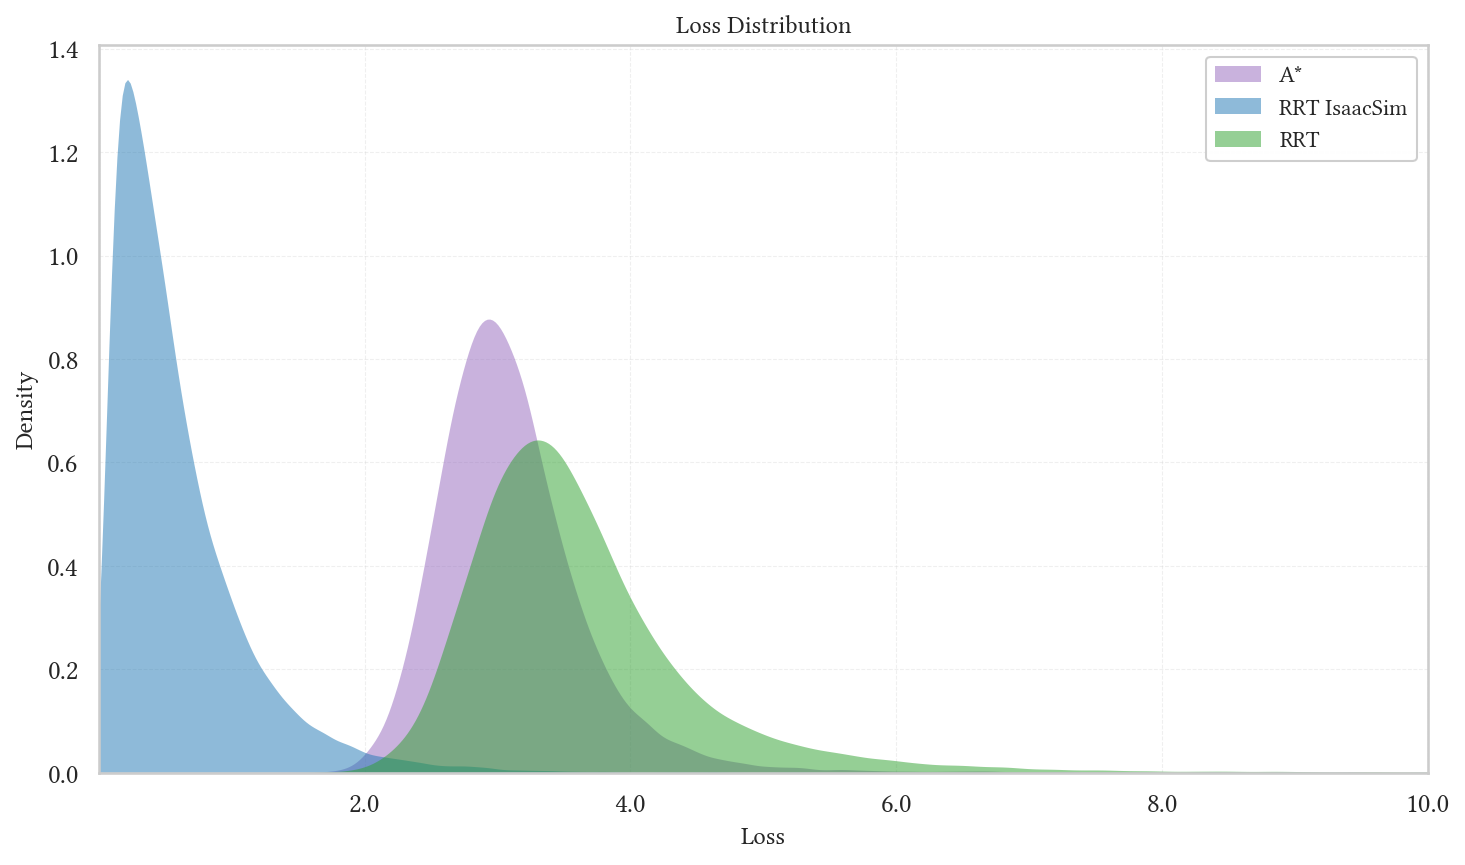

In [17]:
# Loss distribution with filled KDE curves (like the reference image)
with sns.axes_style("whitegrid", rc={'font.family': plt.rcParams['font.family']}):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    from scipy.stats import gaussian_kde
    
    for name in ['A*', 'RRT IsaacSim', 'RRT']:
        if name in loss_by_timestep:
            data = loss_by_timestep[name]
            
            # Create KDE (kernel density estimation)
            kde = gaussian_kde(data['Loss'])
            
            # Generate x values for smooth curve (0 to 10)
            x_range = np.linspace(0, 10, 500)
            y_values = kde(x_range)
            
            # Plot filled KDE curve (no outline, no edge lines)
            ax.fill_between(x_range, 0, y_values, 
                           color=color_map[name], alpha=0.5, label=name,
                           linewidth=0, edgecolor='none')  # Remove all lines
    
    ax.set_xlabel('Loss', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Loss Distribution', fontsize=12, fontweight='normal')
    
    # Set x-axis range and ticks: 0.0 (hidden), 2.0, 4.0, 6.0, 8.0, 10.0
    ax.set_xlim(0, 10)
    ax.set_xticks([0, 2, 4, 6, 8, 10])
    
    # Hide 0 on x-axis
    def hide_zero_x(x, pos):
        if x == 0:
            return ''
        return f'{x:.1f}'
    from matplotlib.ticker import FuncFormatter as FF
    ax.xaxis.set_major_formatter(FF(hide_zero_x))
    
    # Set y-axis to start from 0
    ax.set_ylim(bottom=0)
    
    ax.legend(fontsize=11, loc='best', framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

### 5.4 Q-Value Convergence Analysis

In [18]:
# Q-value convergence - TRUE indicator of when training converged
# When Q-values stabilize, the agent has learned optimal value estimates
# Load Q-value data from training CSV files (episode-wise with multiple smoothing methods)

# Define training CSV file paths
training_csv_files = {
    'A*': r'C:\isaacsim\cobotproject\scripts\Reinforcement Learning\doubleDQN_script\logs\log1\ddqn_astar_grid4_cubes9_20251220_022000_training.csv',
    'RRT IsaacSim': r'C:\isaacsim\cobotproject\scripts\Reinforcement Learning\doubleDQN_script\logs\log1\ddqn_rrt_isaacsim_grid4_cubes9_20251224_185752_training.csv',
    'RRT': r'C:\isaacsim\cobotproject\scripts\Reinforcement Learning\doubleDQN_script\logs\log1\ddqn_rrt_viz_grid4_cubes9_20251220_134808_training.csv'
}

# Smoothing functions
def apply_no_smoothing(data):
    return data

def apply_running_average(data, window=50):
    """Simple running average"""
    return np.convolve(data, np.ones(window)/window, mode='same')

def apply_gaussian(data, sigma=20):
    """Gaussian smoothing"""
    return gaussian_filter1d(data, sigma=sigma)

def apply_exponential_moving_average(data, alpha=0.05):
    """Exponential moving average (EMA)"""
    ema = np.zeros_like(data)
    ema[0] = data[0]
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]
    return ema

def apply_time_weighted_ema(data, span=50):
    """Time-weighted exponential moving average"""
    alpha = 2 / (span + 1)
    return apply_exponential_moving_average(data, alpha)

# Load Q-value data from training CSV files (episode-wise)
qvalue_data_raw = {}
for name, csv_path in training_csv_files.items():
    try:
        df = pd.read_csv(csv_path)
        
        # Look for q_value column
        qvalue_col = None
        for col in df.columns:
            if 'q_value' in col.lower() or 'qvalue' in col.lower():
                qvalue_col = col
                break
        
        # Look for episode column
        episode_col = None
        for col in df.columns:
            if 'episode' in col.lower():
                episode_col = col
                break
        
        if qvalue_col is not None and episode_col is not None:
            # Filter valid data (remove NaN values)
            valid_mask = (df[qvalue_col].notna()) & (df[episode_col].notna())
            
            # Group by episode and calculate mean Q-value per episode
            episode_qvalues = df[valid_mask].groupby(episode_col)[qvalue_col].mean().reset_index()
            
            episodes = episode_qvalues[episode_col].values
            qvalues = episode_qvalues[qvalue_col].values
            
            qvalue_data_raw[name] = {
                'episode': episodes,
                'q_value_raw': qvalues
            }
            print(f'{name}: Loaded {len(df)} training steps, {len(episodes)} episodes from CSV')
            print(f'  Episode range: {episodes.min()} to {episodes.max()}')
            print(f'  Q-value range: {qvalues.min():.4f} to {qvalues.max():.4f}')
        else:
            print(f'{name}: Q-value or episode column not found in CSV')
            print(f'  Available columns: {list(df.columns)}')
    except Exception as e:
        print(f'{name}: Error loading CSV - {e}')

A*: Loaded 50000 training steps, 5556 episodes from CSV
  Episode range: 0 to 5555
  Q-value range: -0.0436 to 125.6870
RRT IsaacSim: Loaded 50000 training steps, 5556 episodes from CSV
  Episode range: 0 to 5555
  Q-value range: -0.0057 to 123.3690
RRT: Loaded 50000 training steps, 5556 episodes from CSV
  Episode range: 0 to 5555
  Q-value range: -0.0505 to 154.5097


In [19]:
# Improved Q-value convergence detection using rolling window statistics
# Based on RL best practices: use rolling window variance and coefficient of variation
print("\nQ-Value Convergence Analysis (Rolling Window Method):")
print("=" * 80)
print("\nMethod: Sliding window with coefficient of variation (CV) threshold")
print("Convergence criteria: CV < 5% for sustained period (100 episodes)")
print("CV = (std / mean) * 100 - measures relative variability\n")

convergence_results = {}

for name in ['A*', 'RRT IsaacSim', 'RRT']:
    if name in qvalue_data_raw:
        data = qvalue_data_raw[name]
        episodes = data['episode']
        qvalues = data['q_value_raw']
        
        # Parameters for convergence detection
        window_size = 100  # Rolling window size (episodes)
        cv_threshold = 5.0  # Coefficient of variation threshold (%)
        sustained_period = 100  # Episodes to maintain low CV
        
        # Calculate rolling statistics
        rolling_mean = pd.Series(qvalues).rolling(window=window_size, min_periods=window_size).mean()
        rolling_std = pd.Series(qvalues).rolling(window=window_size, min_periods=window_size).std()
        
        # Calculate coefficient of variation (CV) - relative variability
        # CV = (std / mean) * 100
        rolling_cv = (rolling_std / rolling_mean.abs()) * 100
        
        # Find first episode where CV drops below threshold and stays there
        converged_episode = None
        for i in range(len(rolling_cv) - sustained_period):
            if not pd.isna(rolling_cv.iloc[i]):
                # Check if CV is below threshold for sustained period
                window_cvs = rolling_cv.iloc[i:i+sustained_period]
                if (window_cvs < cv_threshold).all():
                    converged_episode = int(episodes[i])
                    break
        
        # Store results
        convergence_results[name] = {
            'converged_episode': converged_episode,
            'rolling_mean': rolling_mean,
            'rolling_std': rolling_std,
            'rolling_cv': rolling_cv
        }
        
        # Print results
        print(f"\n{name}:")
        if converged_episode is not None:
            qvalue_at_convergence = rolling_mean.iloc[np.where(episodes == converged_episode)[0][0]]
            qvalue_final = rolling_mean.iloc[-1]
            cv_at_convergence = rolling_cv.iloc[np.where(episodes == converged_episode)[0][0]]
            cv_final = rolling_cv.iloc[-1]
            
            print(f"  ✅ CONVERGED at episode: {converged_episode}")
            print(f"  Q-value at convergence: {qvalue_at_convergence:.4f}")
            print(f"  Q-value final (last window): {qvalue_final:.4f}")
            print(f"  CV at convergence: {cv_at_convergence:.2f}%")
            print(f"  CV final: {cv_final:.2f}%")
            print(f"  Change after convergence: {abs(qvalue_final - qvalue_at_convergence):.4f} ({abs(qvalue_final - qvalue_at_convergence)/max(abs(qvalue_at_convergence), 0.001)*100:.2f}%)")
        else:
            cv_min = rolling_cv.min()
            cv_final = rolling_cv.iloc[-1]
            print(f"  ⚠️  DID NOT CONVERGE within training period")
            print(f"  Minimum CV achieved: {cv_min:.2f}%")
            print(f"  Final CV: {cv_final:.2f}%")
            print(f"  (Threshold: {cv_threshold}% for {sustained_period} episodes)")


Q-Value Convergence Analysis (Rolling Window Method):

Method: Sliding window with coefficient of variation (CV) threshold
Convergence criteria: CV < 5% for sustained period (100 episodes)
CV = (std / mean) * 100 - measures relative variability


A*:
  ⚠️  DID NOT CONVERGE within training period
  Minimum CV achieved: 6.12%
  Final CV: 7.13%
  (Threshold: 5.0% for 100 episodes)

RRT IsaacSim:
  ✅ CONVERGED at episode: 383
  Q-value at convergence: 97.8727
  Q-value final (last window): 105.0570
  CV at convergence: 4.87%
  CV final: 1.98%
  Change after convergence: 7.1842 (7.34%)

RRT:
  ⚠️  DID NOT CONVERGE within training period
  Minimum CV achieved: 7.17%
  Final CV: 9.40%
  (Threshold: 5.0% for 100 episodes)


In [20]:
# Detailed diagnostic: Verify convergence detection
print("\n" + "="*80)
print("DETAILED CONVERGENCE DIAGNOSTIC")
print("="*80)

for name in ['A*', 'RRT IsaacSim', 'RRT']:
    if name in convergence_results:
        print(f"\n{name}:")
        print("-" * 40)
        
        rolling_cv = convergence_results[name]['rolling_cv']
        rolling_mean = convergence_results[name]['rolling_mean']
        converged_episode = convergence_results[name]['converged_episode']
        
        # Show CV statistics
        valid_cv = rolling_cv.dropna()
        print(f"CV Statistics:")
        print(f"  Min CV: {valid_cv.min():.2f}%")
        print(f"  Max CV: {valid_cv.max():.2f}%")
        print(f"  Mean CV: {valid_cv.mean():.2f}%")
        print(f"  Final CV: {valid_cv.iloc[-1]:.2f}%")
        
        # Show where CV drops below 5%
        below_threshold = valid_cv < 5.0
        if below_threshold.any():
            first_below = below_threshold.idxmax()
            episodes_below = below_threshold.sum()
            print(f"\nEpisodes with CV < 5%: {episodes_below} out of {len(valid_cv)}")
            print(f"First episode with CV < 5%: {first_below}")
            
            # Check sustained period
            if converged_episode is not None:
                print(f"\n✅ Sustained convergence detected at episode {converged_episode}")
                print(f"   (CV < 5% for 100 consecutive episodes)")
            else:
                print(f"\n⚠️  CV drops below 5% but NOT sustained for 100 episodes")
                print(f"   (Temporary dips don't count as convergence)")
        else:
            print(f"\n❌ CV never drops below 5% threshold")
        
        # Show Q-value range
        valid_qmean = rolling_mean.dropna()
        print(f"\nQ-Value Range (rolling mean):")
        print(f"  Min: {valid_qmean.min():.2f}")
        print(f"  Max: {valid_qmean.max():.2f}")
        print(f"  Final: {valid_qmean.iloc[-1]:.2f}")


DETAILED CONVERGENCE DIAGNOSTIC

A*:
----------------------------------------
CV Statistics:
  Min CV: 6.12%
  Max CV: 3080.43%
  Mean CV: 12.42%
  Final CV: 7.13%

❌ CV never drops below 5% threshold

Q-Value Range (rolling mean):
  Min: -0.01
  Max: 98.84
  Final: 97.37

RRT IsaacSim:
----------------------------------------
CV Statistics:
  Min CV: 0.59%
  Max CV: 840.33%
  Mean CV: 4.59%
  Final CV: 1.98%

Episodes with CV < 5%: 5173 out of 5457
First episode with CV < 5%: 383

✅ Sustained convergence detected at episode 383
   (CV < 5% for 100 consecutive episodes)

Q-Value Range (rolling mean):
  Min: 0.01
  Max: 105.12
  Final: 105.06

RRT:
----------------------------------------
CV Statistics:
  Min CV: 7.17%
  Max CV: 4192.23%
  Mean CV: 12.52%
  Final CV: 9.40%

❌ CV never drops below 5% threshold

Q-Value Range (rolling mean):
  Min: -0.02
  Max: 123.65
  Final: 120.46



Creating Q-Value Convergence Plot...

Smoothing Method: Rolling Mean (window=100 episodes)
This is a simple moving average - NOT Gaussian smoothing



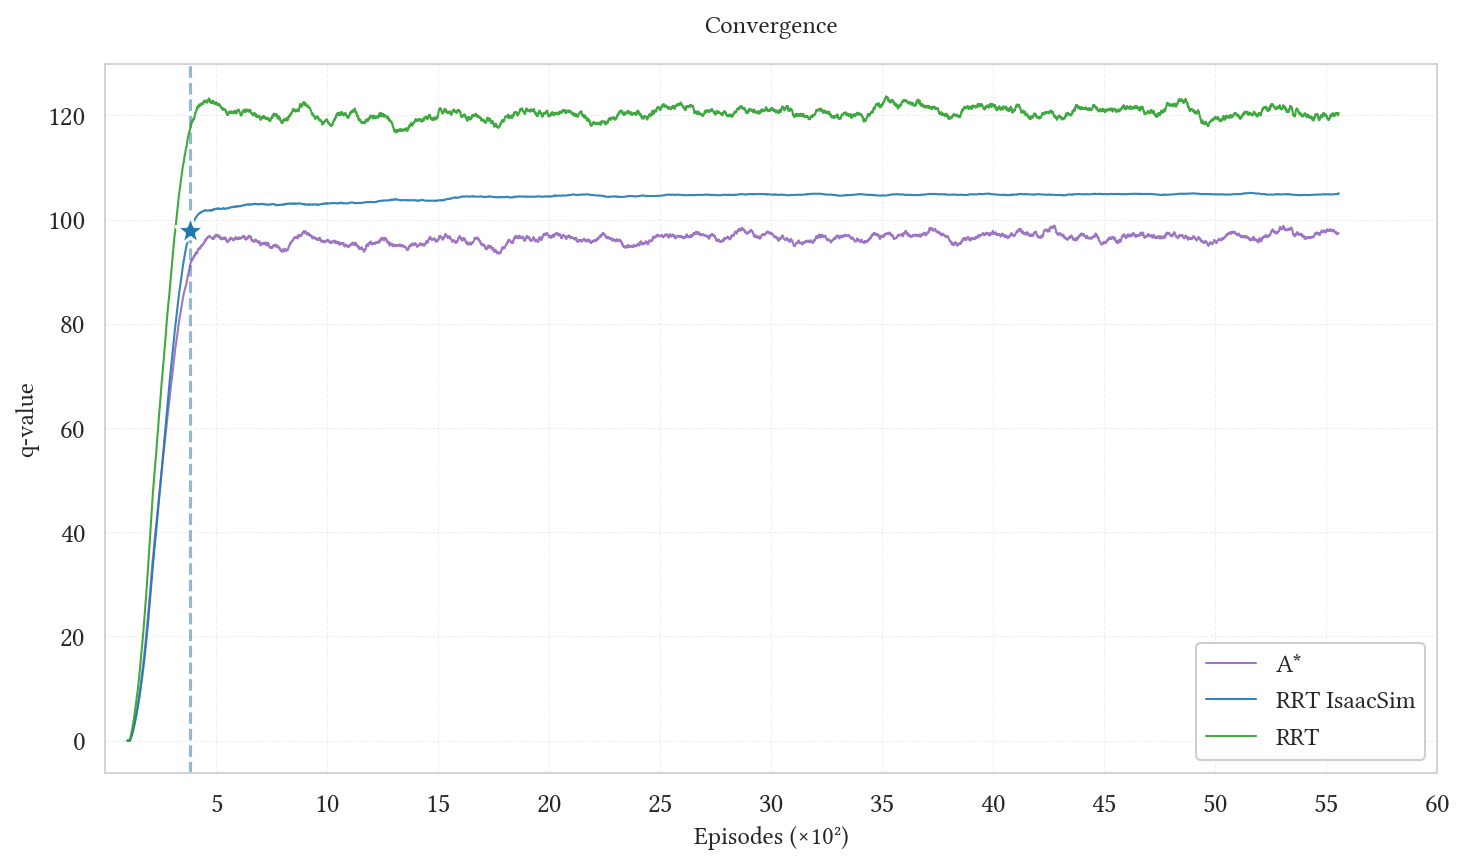


✅ Plot complete! Convergence points marked with stars (⭐)


In [23]:
# Plot Q-value convergence with rolling mean and convergence markers
print("\n" + "="*80)
print("Creating Q-Value Convergence Plot...\n")
print("Smoothing Method: Rolling Mean (window=100 episodes)")
print("This is a simple moving average - NOT Gaussian smoothing\n")

with sns.axes_style("whitegrid", rc={'font.family': plt.rcParams['font.family']}):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for name in ['A*', 'RRT IsaacSim', 'RRT']:
        if name in qvalue_data_raw and name in convergence_results:
            data = qvalue_data_raw[name]
            episodes = data['episode']
            
            # Get rolling mean from convergence analysis
            rolling_mean = convergence_results[name]['rolling_mean']
            converged_episode = convergence_results[name]['converged_episode']
            
            # Convert episodes to hundreds (×10²)
            x_values = episodes / 100
            
            # Plot rolling mean line
            ax.plot(x_values, rolling_mean, 
                   label=name, color=color_map[name], 
                   linewidth=1.0, alpha=0.9)
            
            # Mark convergence point with vertical line and star marker only
            if converged_episode is not None:
                conv_x = converged_episode / 100
                conv_idx = np.where(episodes == converged_episode)[0][0]
                conv_y = rolling_mean.iloc[conv_idx]
                
                # Vertical line at convergence
                ax.axvline(x=conv_x, color=color_map[name], linestyle='--', 
                          linewidth=1.5, alpha=0.5)
                
                # Marker at convergence point
                ax.plot(conv_x, conv_y, marker='*', markersize=15, 
                       color=color_map[name], markeredgecolor='white', 
                       markeredgewidth=1.5, zorder=5)
    
    ax.set_xlabel('Episodes (×10²)', fontsize=12)
    ax.set_ylabel('q-value', fontsize=12)
    ax.set_title('Convergence', fontsize=12, pad=15)
    
    # Set x-axis ticks at intervals of 5 (representing 500 episodes)
    max_x = max([data['episode'].max() for data in qvalue_data_raw.values()]) / 100
    ax.set_xticks(np.arange(0, max_x + 5, 5))
    
    # Hide 0 on x-axis
    def hide_zero_x(x, pos):
        if x == 0:
            return ''
        return f'{int(x)}'
    ax.xaxis.set_major_formatter(FuncFormatter(hide_zero_x))
    ax.set_xlim(left=0)
    
    ax.legend(fontsize=12, loc='lower right', framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Fix border thickness - make all spines the same width
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
        spine.set_edgecolor('#CCCCCC')
    
    plt.tight_layout()
    plt.show()
    
print("\n✅ Plot complete! Convergence points marked with stars (⭐)")